In [240]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
from algorithms import ChainTopology, RingTopology, QuadraticsTask, relaysum_model, relaysum_grad, relaysum_mix, all_reduce, gossip, d2, gradient_tracking, BinaryTreeTopology, relaysum_grad_overlap, time_varying_sgp
from random_quadratics import RandomQuadraticsTask
from compute_correction_factor import compute_lr_correction
import torch
import math
import tuning
import pandas as pd
from warehouse import Warehouse

In [276]:
torch.set_default_dtype(torch.float64)

# Reach a fixed plateau

In [277]:
num_workers = 32
d = 10
# noise = 0
noise = 0.05
mu = 0.5
zetas = [0, .1, 10]
max_steps = [2000, 2000, 2000, 2000]
eval_intervals = [30, 30, 60, 100]
plateau = 1e-6
seed = 0

In [278]:
warehouse = Warehouse()

In [279]:
algorithm_name = "Gossip"
algorithm = gossip
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=0, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    print(steps, learning_rate)
    if learning_rate is None:
        continue
    learning_rate = min(learning_rate, 0.02)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
13 1.25
8.030034166289929e-07
Tuning for 0.1
1469 0.0103759765625
1.2620691683395968e-06
Tuning for 10
19818 0.000762939453125
0.09901161034004247


In [281]:
algorithm_name = "D2"
algorithm = d2
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=0, mu=mu, seed=seed)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    if learning_rate is None:
        continue
    learning_rate = min(learning_rate, 0.02)
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps, gossip_weight=1/3-0.01):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

18 0.394287109375
9.808477941439341e-07
34 0.1953125
1.1967329169859653e-06
54 0.15625
1.2580164199249566e-06


In [280]:
algorithm_name = "Gradient tracking"
algorithm = gradient_tracking
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=0, mu=mu, seed=seed)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    if learning_rate is None:
        continue
    learning_rate = min(learning_rate, 0.02)
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps, gossip_weight=1/3-0.01):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

10 0.4345703125
9.9102180044712e-07
301 0.019330978393554688
6.319424846190635e-07
641 0.0095367431640625
5.211581424191536e-07


In [282]:
algorithm_name = "RelaySum/Model"
algorithm = relaysum_model
topology_name = "chain"
topology = ChainTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=0, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    if learning_rate is None:
        continue
    learning_rate = min(learning_rate, 0.2)
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

51 0.869140625
8.088465411544305e-07
51 0.869140625
9.53415988158568e-07
54 0.8984375
2.5371610767876973e-07


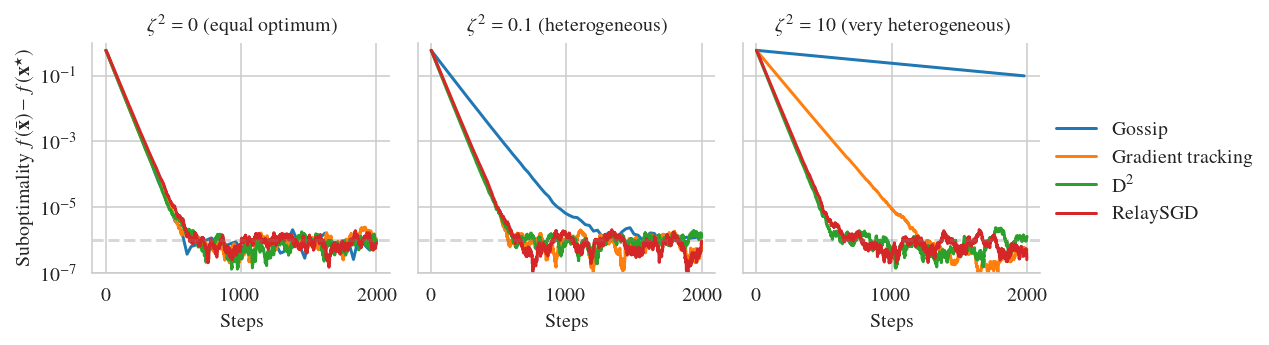

In [283]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
})

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", 10: "10 (very heterogeneous)", .1: "0.1 (heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False);
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
g.set(ylim=[1e-7, 1])
g.add_legend(title="");

In [284]:
g.savefig("effect_of_heterogeneity_fixed_saturation_noisy.pdf", bbox_inches="tight")

# Noise saturation level & scaling workers

In [171]:
warehouse = Warehouse()

In [226]:
num_steps = 1000
eval_interval = 5
zeta2 = 0.1


for algorithm, algorithm_name in ((relaysum_model, "RelaySum/Model"), (d2, "D2"), (relaysum_grad, "RelaySum/Grad"), (gossip, "Gossip")):
    print(algorithm_name)
    warehouse.clear("error", {"algorithm": algorithm_name})

    for num_workers in [2, 4, 8, 16, 32, 64]:
        if "RelaySum" in algorithm_name:
            topology = ChainTopology(num_workers)
            topology_name = "chain"
            args = {}
        else:
            topology = RingTopology(num_workers)
            topology_name = "ring"
        tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2, "n": num_workers}
        learning_rate = 0.1 
        if algorithm == relaysum_model:
            learning_rate *= compute_lr_correction(topology, algorithm)
        task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
        warehouse.clear("error", tags)
        errors = {}
        for iterate in algorithm(task, topology, learning_rate, num_steps):
            if iterate.step % eval_interval == 0:
                error = task.error(iterate.state).item() #/ initial_error
                errors[iterate.step] = error
    #             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
    #                 print("no improvement after", iterate.step)
    #                 break
                if error < 1e-12:
                    break
                warehouse.log_metric(
                    "error", {"value": error, "step": iterate.step}, tags
                )
        print(error)

RelaySum/Model
6.594377673918572e-07
1.6052992268811295e-12
9.79827330382932e-13
8.130163209330021e-13
8.539557949660548e-13
8.323619571370955e-13
D2
6.593973261859176e-07
1.5946133302691123e-12
8.647249583049188e-13
8.428813202954188e-13
9.741096818061123e-13
7.900069487476458e-13
RelaySum/Grad
6.594377673918572e-07
9.714539947663914e-06
9.542821675700974e-06
9.93019566616904e-06
8.902807497795928e-06
6.145573966526152e-06
Gossip
2.7676548617572294e-05
1.3870977559837794e-05
8.0774743203893e-05
0.00025224235352683255
0.00033283865112040956
0.00023184630912612136


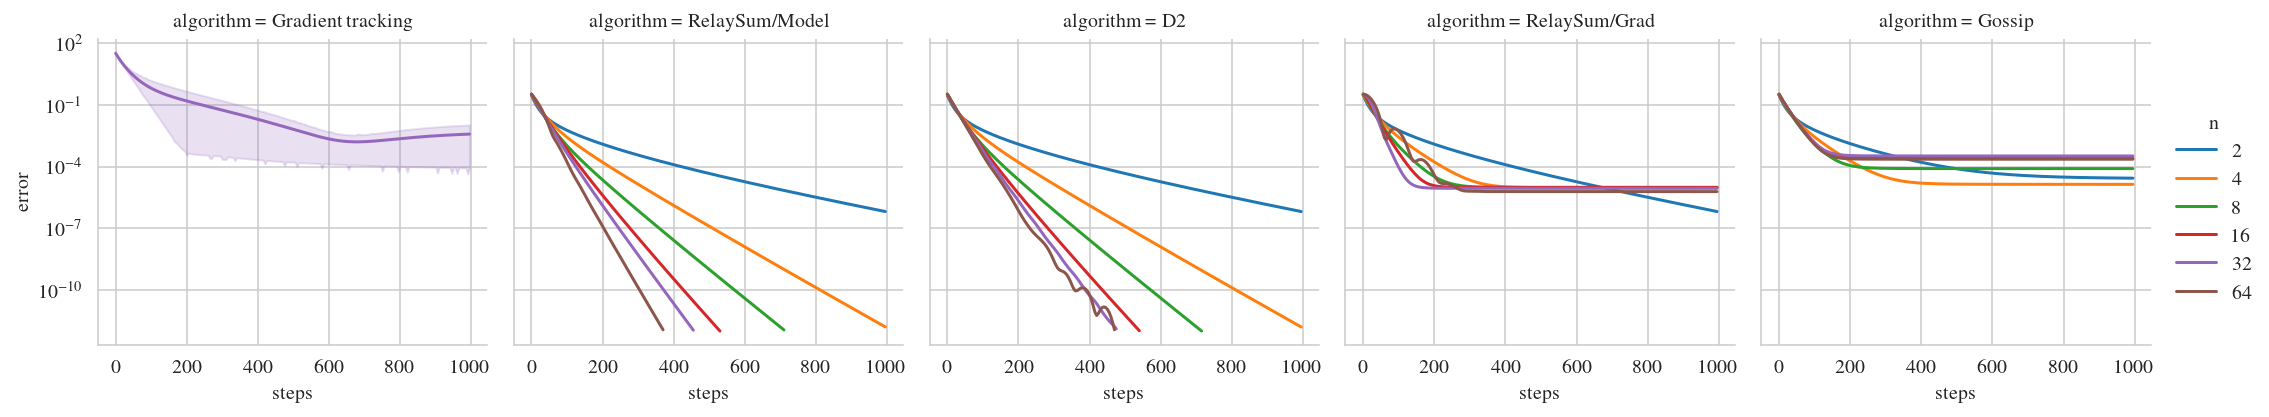

In [227]:
g = warehouse.show("error", hue="n", col="algorithm")
g.set(yscale="log")
g.add_legend()

# Test dependence on p of gradient tracking

In [230]:
warehouse = Warehouse()

In [237]:
num_steps = 1000
eval_interval = 5
zeta2 = 1
mu = 0.01
noise = 0
d = 100
num_workers = 32

for algorithm, algorithm_name in ((gradient_tracking, "Gradient tracking"), (d2, "D2"), (relaysum_model, "RelaySum/Model"), (time_varying_sgp, "Time-varying SGP")):

    print(algorithm_name)
    warehouse.clear("error", {"algorithm": algorithm_name})

    for gossip_weight in [0.001, 0.01, 0.1, 0.33]:

        if "RelaySum" in algorithm_name:
            topology = ChainTopology(num_workers)
            args = {}
            topology_name = "chain"
        elif "SGP" in algorithm_name:
            topology = RingTopology(num_workers)
            args = {}
            topology_name = "ring"
        else:
            topology = RingTopology(num_workers)
            args = {"gossip_weight": gossip_weight}
            topology_name = "ring"
        tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2, "n": num_workers, "gossipweight": gossip_weight}
        learning_rate = 0.1 
        if algorithm == relaysum_model:
            learning_rate *= compute_lr_correction(topology, algorithm)
        task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed, r0=10)
        warehouse.clear("error", tags)
        errors = {}
        for iterate in algorithm(task, topology, learning_rate, num_steps, **args):
            if iterate.step % eval_interval == 0:
                error = task.error(iterate.state).item() #/ initial_error
                errors[iterate.step] = error
        #             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
        #                 print("no improvement after", iterate.step)
        #                 break
                if error < 1e-12:
                    break
                warehouse.log_metric(
                    "error", {"value": error, "step": iterate.step}, tags
                )
        print(error)

Gradient tracking
0.03344400074250542
0.009290299206032637
0.0016828278615896863
9.481403628441853e-06
D2
0.0005661807546737396
1.1036949132403606e-11
4.212186155427844e-13
8.275602425555917e-13
RelaySum/Model
8.872902412804251e-13
8.872902412804251e-13
8.872902412804251e-13
8.872902412804251e-13
Time-varying SGP
8.145140063087197e-06
8.145140063087197e-06
8.145140063087197e-06
8.145140063087197e-06


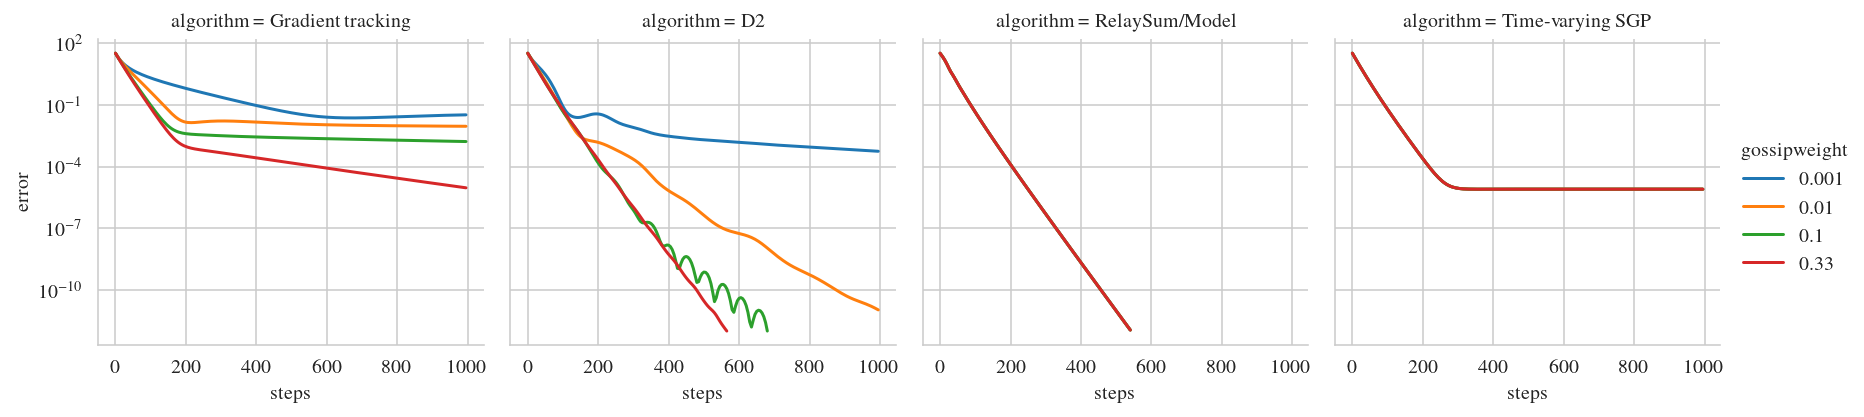

In [238]:
g = warehouse.show("error", hue="gossipweight", col="algorithm")
g.set(yscale="log")
g.add_legend()

# Trash bin

In [118]:
algorithm_name = "RelaySum/Grad"
algorithm = relaysum_grad
topology_name = "chain"
topology = ChainTopology(num_workers)
seed = 3

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=0, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    if learning_rate is None:
        continue
    learning_rate = min(learning_rate, 0.02)
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

145 0.05859375
1.6978782468868303e-06
145 0.05859375
5.485489964485168e-07
141 0.05859375
9.5367431640625e-07
